Source:

This code is written by Himanshu Rawlani

Github:
https://github.com/himanshurawlani/convnet-interpretability-keras/blob/master/Visualizing%20using%20deconvnets/deconvnet_keras.ipynb

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [1]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
K.set_image_data_format('channels_last')

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

Using TensorFlow backend.


Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'french_bulldog.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [4]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02108915', 'French_bulldog', 0.86868966), ('n02096585', 'Boston_bull', 0.027795734), ('n02093256', 'Staffordshire_bullterrier', 0.017619632)]



The top-3 classes predicted for this image are:

* French Bulldog (with 86.8% probability)
* Buston Bull (with 2.7% probability)
* Staffordshire Bullterrier (with 1.7% probability)

Thus our network has recognized our image as containing an undetermined quantity of French Bulldog. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "French Bulldog" class, at index 245:

In [5]:
preds.shape

(1, 1000)

In [6]:
np.argmax(preds[0])

245

To visualize which parts of our image were the most contributing to the output, let's set up the Grad-CAM process:

In [7]:
#layer_names = ['block1_conv1', 'block1_conv2', 
#               'block2_conv1', 'block2_conv2', 
#               'block3_conv1', 'block3_conv2', 'block3_conv3', 
#               'block4_conv1', 'block4_conv2', 'block4_conv3', 
#               'block5_conv1', 'block5_conv2', 'block5_conv3']

layer_names = ['block1_conv1', 'block3_conv2', 'block5_conv1']

In [8]:
# This is the entry in the prediction vector
pred_vector_output = model.output[:, 386]

heatmap = []
for layer_name in layer_names:
    # The is the output feature map of the given layer, in VGG16
    some_conv_layer = model.get_layer(layer_name)

    # This is the gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(model.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap.append(np.mean(conv_layer_output_value, axis=-1))

In [9]:
len(heatmap)

3

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

For visualization purpose, we will also normalize the heatmap between 0 and 1:

<Figure size 1296x1296 with 0 Axes>

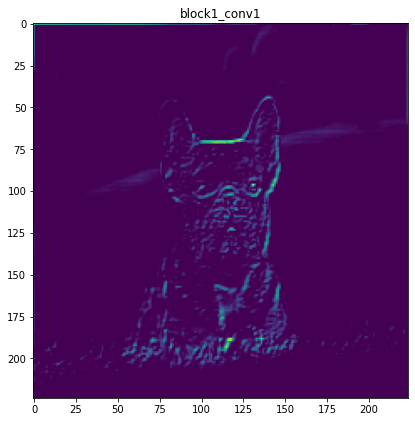

ERROR! Session/line number was not unique in database. History logging moved to new session 462


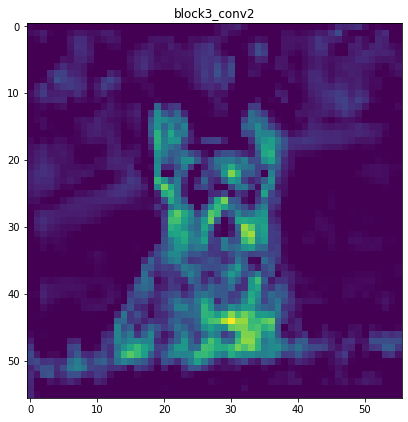

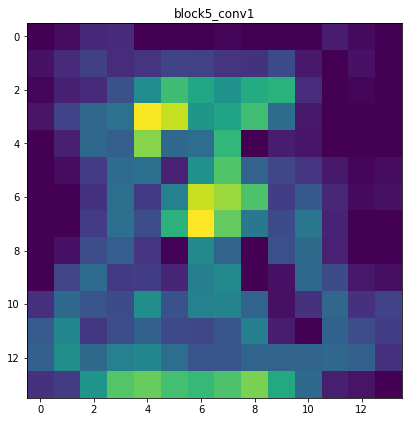

In [11]:
plt.figure(figsize=(18, 18))
for i in range(3):
    plt.figure(figsize=(40,40))
    plt.subplot(5, 3, i+1)
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [17]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)
for i, hm in enumerate(heatmap):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    # We resize the heatmap to have the same size as the original image
    img_hm = cv2.resize(img_heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    img_hm = np.uint8(255 * img_hm)

    # We apply the heatmap to the original image
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.4 + img

    # Save the image to disk
    cv2.imwrite('./french_bulldog_{}.jpg'.format(layer_names[i]), superimposed_img)

Text(0.5, 1.0, 'input_image')

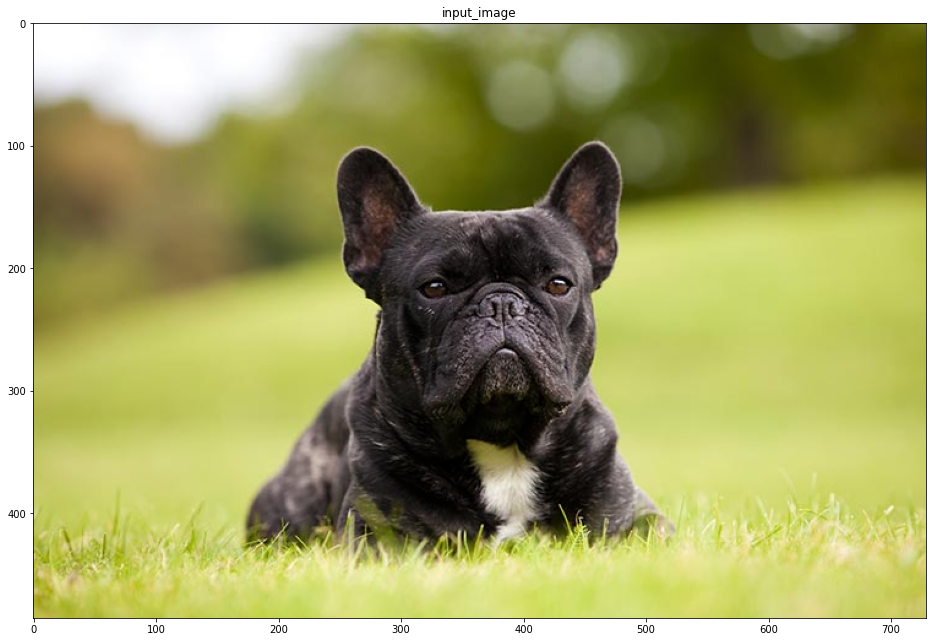

In [13]:
plt.figure(figsize=(16, 16))
layer_name = 'input_image'
img = image.img_to_array(
    image.load_img('./french_bulldog.jpg')) / 255.
plt.imshow(img)
plt.title(layer_name)

Text(0.5, 1.0, 'block1_conv1')

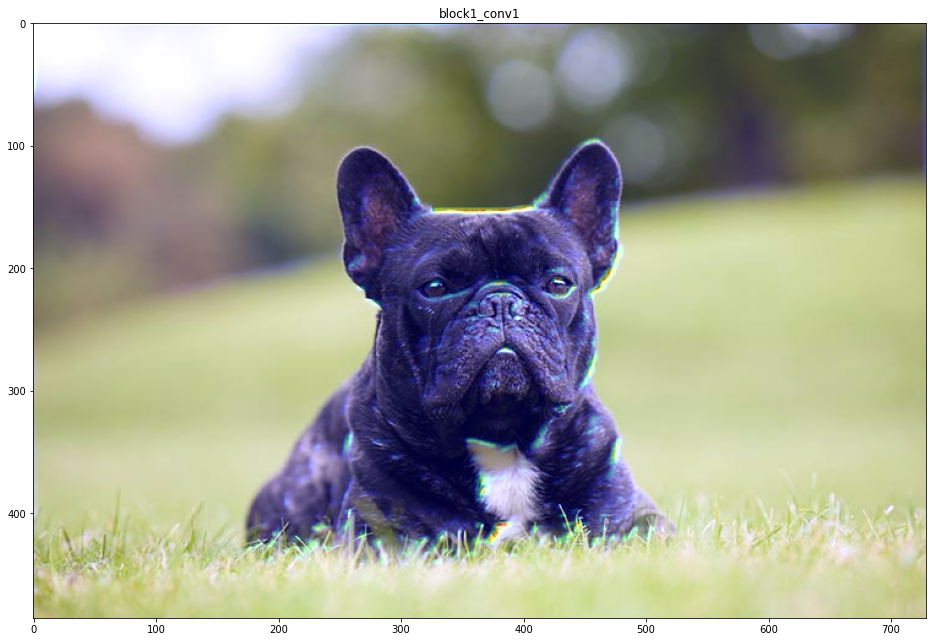

In [14]:
plt.figure(figsize=(16, 16))
layer_name = 'block1_conv1'
img = image.img_to_array(
    image.load_img('./french_bulldog_{}.jpg'.format(layer_name))) / 255.
plt.imshow(img)
plt.title(layer_name)

Text(0.5, 1.0, 'block3_conv2')

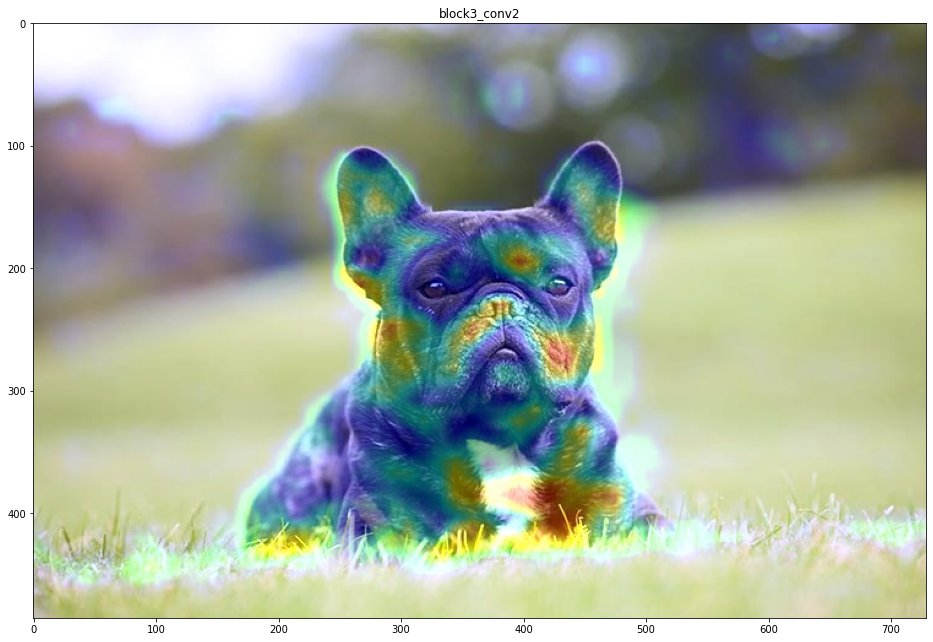

In [15]:
plt.figure(figsize=(16, 16))
layer_name = 'block3_conv2'
img = image.img_to_array(
    image.load_img('./french_bulldog_{}.jpg'.format(layer_name))) / 255.
plt.imshow(img)
plt.title(layer_name)

Text(0.5, 1.0, 'block5_conv1')

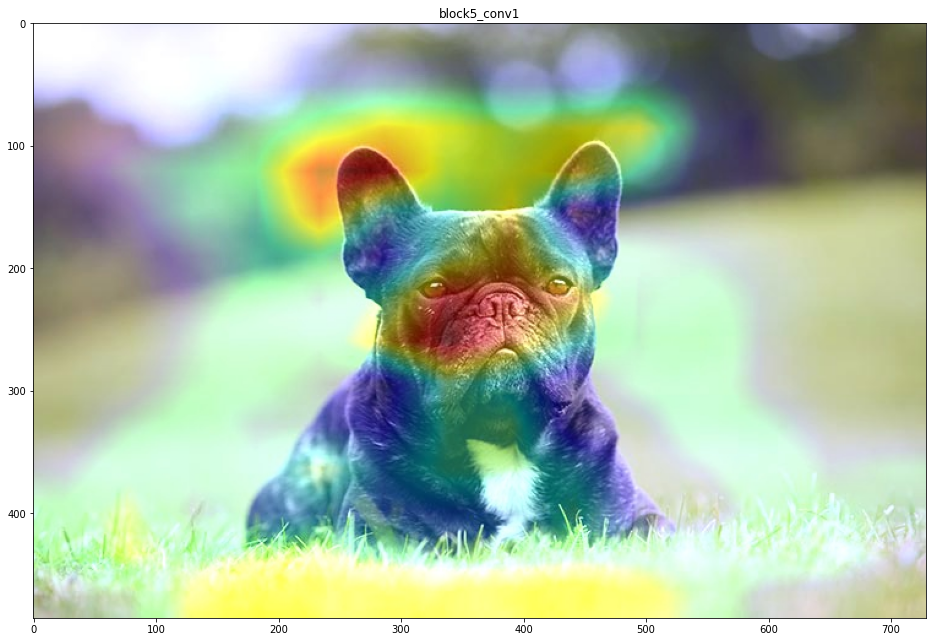

In [16]:
plt.figure(figsize=(16, 16))
layer_name = 'block5_conv1'
img = image.img_to_array(
    image.load_img('./french_bulldog_{}.jpg'.format(layer_name))) / 255.
plt.imshow(img)
plt.title(layer_name)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
